### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load and process data

In [ ]:
# Load data
data = np.load('training_dataset/training_data.npy')
periods = np.load('training_dataset/valid_periods.npy')
categories = np.load('training_dataset/categories.npy')

# Change data type
data = data.astype(np.float32)
periods = periods.astype(np.int32)

# Find all possible labels
labels = []
for label in categories:
  if label not in labels:
    labels.append(label)
labels = sorted(labels)
print(f"Possible labels: {labels}")

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in categories:
    if label == category:
      count = count + 1
  num_elem.update({label: count})
  count = 0
print(f"Number of elements per label: {num_elem}")

# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
periods = periods[indices]
categories = categories[indices]

Possible labels: ['A', 'B', 'C', 'D', 'E', 'F']
Number of elements per label: {'A': 5728, 'B': 10987, 'C': 10017, 'D': 10016, 'E': 10975, 'F': 277}


In [ ]:
# Compute the number of elements in the training set and in the validation set for each label
split_percentage = 0.9

train_dim = {}
val_dim = {}
for label in labels:
  train_dim.update({label: round(num_elem[label] * split_percentage)})
  val_dim.update({label: num_elem[label] - train_dim[label]})

print(f"Number of elements per label: {num_elem}")
print(f"Number of elements per label (Training set): {train_dim}")
print(f"Number of elements per label (Validation set): {val_dim}")

Number of elements per label: {'A': 5728, 'B': 10987, 'C': 10017, 'D': 10016, 'E': 10975, 'F': 277}
Number of elements per label (Training set): {'A': 5155, 'B': 9888, 'C': 9015, 'D': 9014, 'E': 9878, 'F': 249}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 28}


In [ ]:
counter = {}        # Dictionary containing the number of elements inserted in the training set for each label
val_elem = 0        # Number of elements in the validation set
training_elem = 0   # Number of elements in the training set

# Init counter, val_elem, training_elem
for label in labels:
  counter.update({label:0})
  val_elem = val_elem + val_dim[label]
  training_elem = training_elem + train_dim[label]

print(f"Number of training elem: {training_elem}")
print(f"Number of validation elem: {val_elem}")

# Init arrays for training and validation
data_train = np.zeros(shape=(training_elem, data.shape[1]))
data_val = np.zeros(shape=(val_elem, data.shape[1]))
periods_train = np.zeros(shape=(training_elem, periods.shape[1]),dtype='int32')
periods_val = np.zeros(shape=(val_elem, periods.shape[1]),dtype='int32')
category_train = np.chararray((training_elem,))
category_val = np.chararray((val_elem,))

# Split data between training and validation
train_shift = 0
val_shift = 0
for i in range(data.shape[0]):
  if counter[categories[i]] < train_dim[categories[i]]:
    counter[categories[i]] = counter[categories[i]] + 1
    data_train[train_shift] = data[i]
    periods_train[train_shift] = periods[i]
    category_train[train_shift] = categories[i][0]
    train_shift = train_shift + 1
  else:
    data_val[val_shift] = data[i]
    periods_val[val_shift] = periods[i]
    category_val[val_shift] = categories[i][0]
    val_shift = val_shift + 1

Number of training elem: 43199
Number of validation elem: 4801


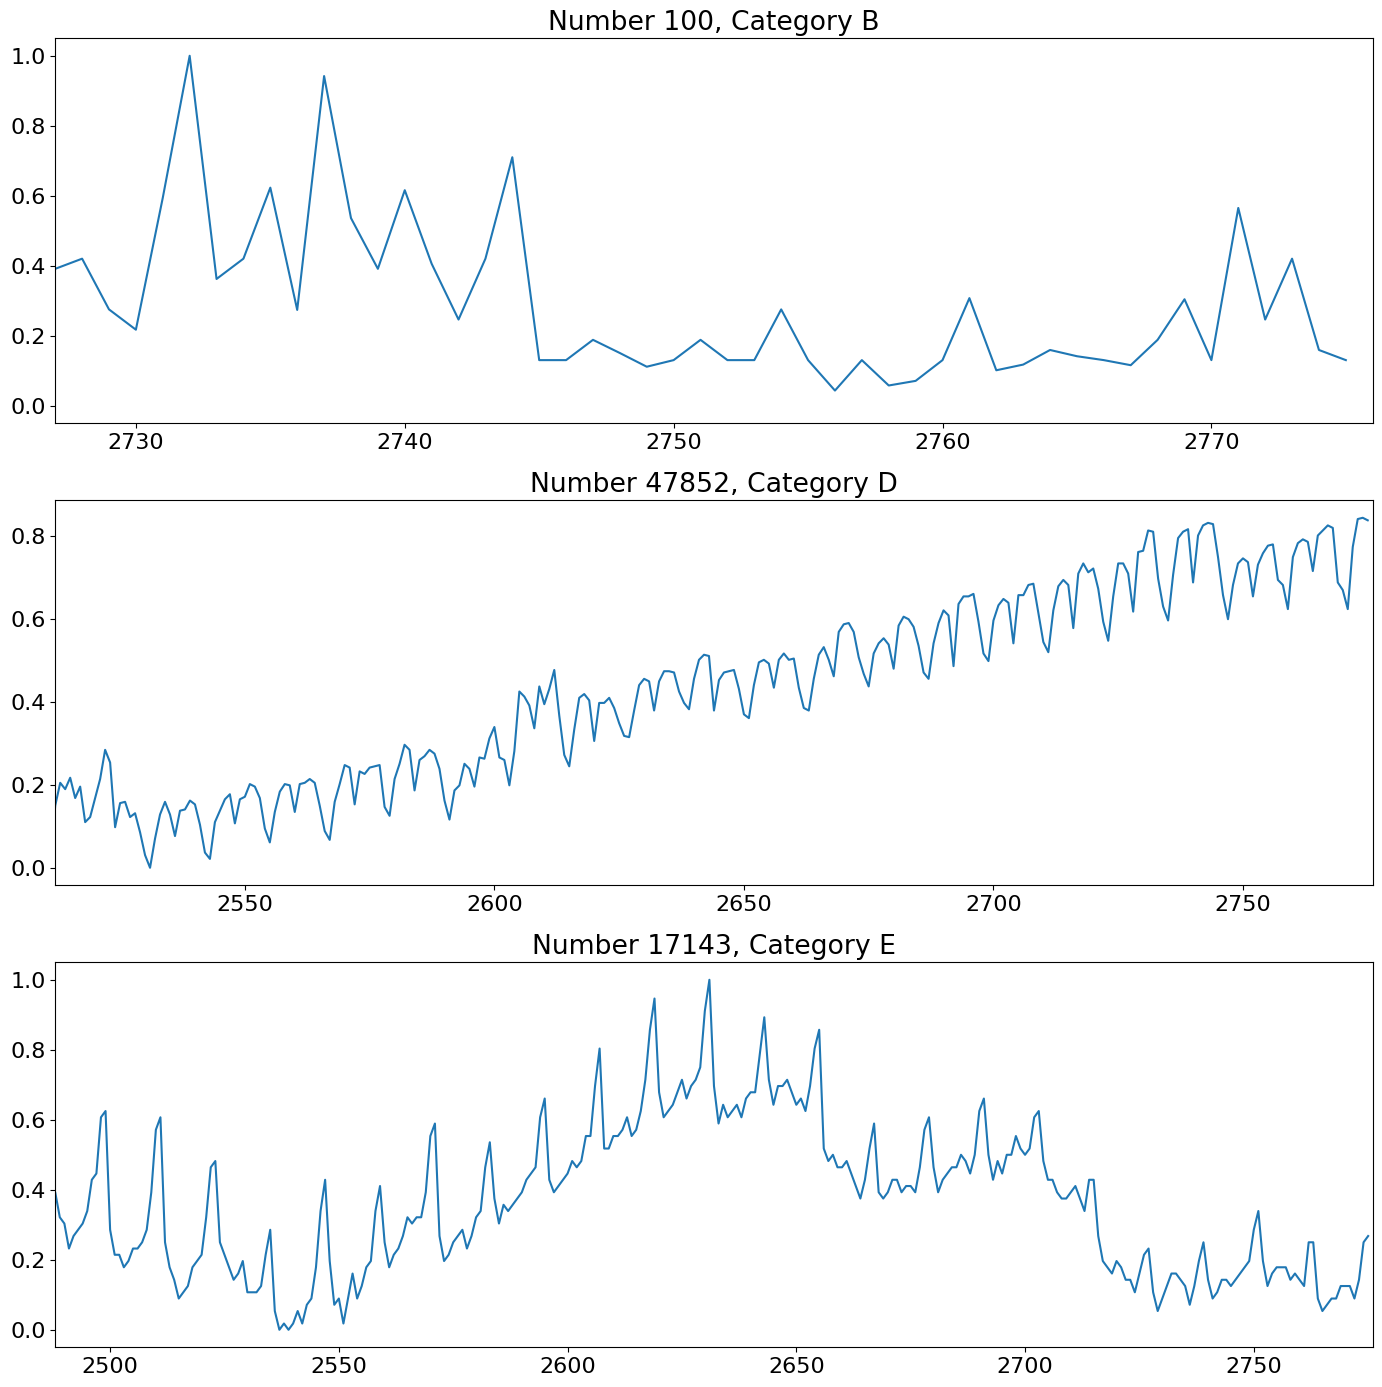

In [ ]:
def inspect_data(data, periods, categories, cols):
  figs, axs = plt.subplots(len(cols), 1, figsize=(17,17))
  for i, col in enumerate(cols):
        axs[i].plot(data[col])
        axs[i].set_title("Number " +str(col)+ ", Category " +str(categories[col]))
        axs[i].set_xlim(periods[col])
  plt.show()

inspect_data(data, periods, categories, [100, 47852, 17143])

In [ ]:
letters = np.unique(categories)
i = 0
for cat in letters:
  categories[categories == cat] = i
  i = i+1
categories = categories.astype(np.int32)
np.unique(categories)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [ ]:
def build_sequences(data, lenghts, categories, target_category, window=200, stride=20, telescope=9):
  assert window % stride == 0
  shape = data.shape
  dataset = []
  labels = []
  for i in np.arange(shape[0]):
    if categories[i] == target_category:
      check = lenghts[i][0]%window
      size = window - check
      if check and shape[1] - lenghts[i][0] - size < 0:
        padding = np.zeros(size - (shape[1] - lenghts[i][0]), dtype='float32')
        temp_data = np.concatenate((padding, data[i]))
      else:
        temp_data = data[i].copy()

      for idx in np.arange(temp_data.shape[0] - lenghts[i][0] - size, shape[1]-window-telescope, stride):
        dataset.append(temp_data[idx:idx+window])
        labels.append(temp_data[idx+window:idx+window+telescope])

  dataset = np.array(dataset)
  labels = np.array(labels)

  return dataset, labels

In [ ]:
def inspect_multivariate(X, y, cols, telescope, title, idx=None):
    figs, axs = plt.subplots(len(cols), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(cols):
        axs[i].plot(np.arange(len(X[0])), X[col])
        axs[i].plot(np.arange(len(X[0]), len(X[0])+telescope), y[col], color='orange')
        axs[i].set_title(title + ' sequence number: ' + str(col))
        axs[i].set_ylim(0,1)
    plt.show()

### Training

In [ ]:
lenghts_train = np.diff(periods_train)
lenghts_val = np.diff(periods_val)
autoregressive_telescope = 9

X_train0, y_train0 = build_sequences(data_train, lenghts_train, categories, 0, telescope = autoregressive_telescope)
X_val0, y_val0 = build_sequences(data_val, lenghts_val, categories, 0, telescope = autoregressive_telescope)
X_train1, y_train1 = build_sequences(data_train, lenghts_train, categories, 1, telescope = autoregressive_telescope)
X_val1, y_val1 = build_sequences(data_val, lenghts_val, categories, 1, telescope = autoregressive_telescope)
X_train2, y_train2 = build_sequences(data_train, lenghts_train, categories, 2, telescope = autoregressive_telescope)
X_val2, y_val2 = build_sequences(data_val, lenghts_val, categories, 2, telescope = autoregressive_telescope)
X_train3, y_train3 = build_sequences(data_train, lenghts_train, categories, 3, telescope = autoregressive_telescope)
X_val3, y_val3 = build_sequences(data_val, lenghts_val, categories, 3, telescope = autoregressive_telescope)
X_train4, y_train4 = build_sequences(data_train, lenghts_train, categories, 4, telescope = autoregressive_telescope)
X_val4, y_val4 = build_sequences(data_val, lenghts_val, categories, 4, telescope = autoregressive_telescope)
X_train5, y_train5 = build_sequences(data_train, lenghts_train, categories, 5, telescope = autoregressive_telescope)
X_val5, y_val5 = build_sequences(data_val, lenghts_val, categories, 5, telescope = autoregressive_telescope)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    filters = 256
    name = 'nome'
    s1 = tfkl.Conv1D(
        filters=filters,
        kernel_size=1,
        padding='same',
        activation='relu',
        name='conv'+name+'-'+str(1)
        )(x)
    s2 = tfkl.Conv1D(
        filters=filters,
        kernel_size=1,
        padding='same',
        activation='relu',
        name='conv'+name+'-'+str(2)
        )(s1)
    s3 = tfkl.Add(name='add'+name)([x,s2])
    s4 = tfkl.ReLU(name='relu'+name)(s3)
    s5 = tfkl.MaxPooling1D(name='pooling'+name)(s4)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 1, padding='same', name='output_layer')(s5)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    output_layer = output_layer[:,:,0]

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

#### Model 0

In [ ]:
print(f"X_train: {X_train0.shape}, y_train: {y_train0.shape}")
print(f"X_val: {X_val0.shape}, y_train: {y_val0.shape}")

input_shape = (X_train0.shape[1],1)
output_shape = (y_train0.shape[1],1)
batch_size = 64
epochs = 200

early_stopping = tfk.callbacks.EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  patience=12,
                  restore_best_weights=True)

lr_scheduling = tfk.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  mode='min',
                  patience=10,
                  factor=0.99,
                  min_lr=1e-5)

print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (46270, 200), y_train: (46270, 9)
X_val: (3390, 200), y_train: (3390, 9)
Input shape: (200, 1), output shape: (9, 1)


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 bidirectional_lstm_2 (Bidi  (None, 200, 256)             394240    ['bidirectional_lstm[0][0]']  
 rectional)                                                                                       
                                                                                    

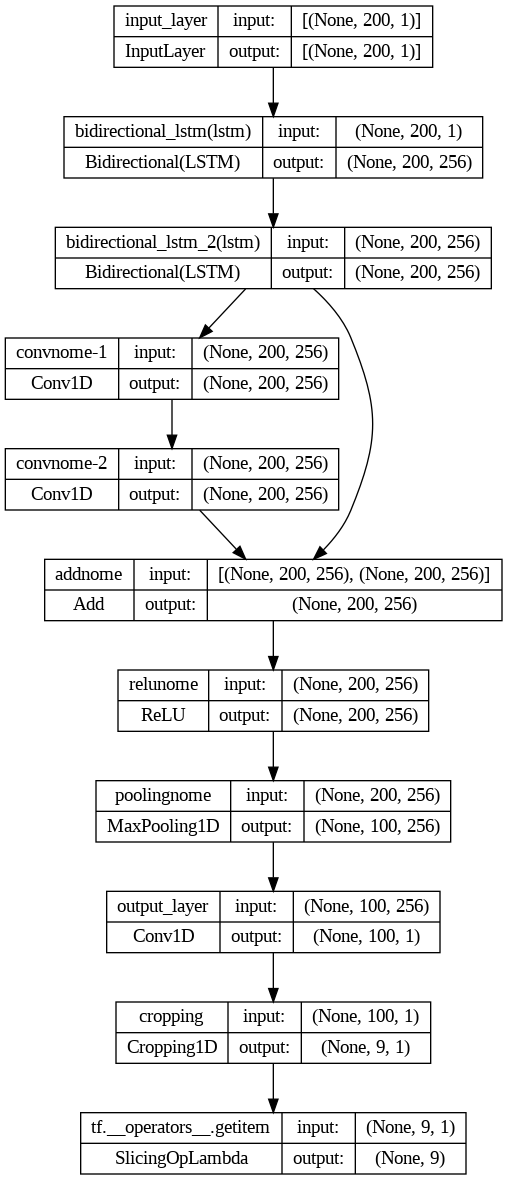

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train0,
    y = y_train0,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val0, y_val0),
    callbacks = [early_stopping, lr_scheduling]
).history

Epoch 1/200
723/723 [==============================] - 47s 49ms/step - loss: 0.0599 - val_loss: 0.0715 - lr: 0.0010
Epoch 2/200
723/723 [==============================] - 35s 49ms/step - loss: 0.0565 - val_loss: 0.0819 - lr: 0.0010
Epoch 3/200
723/723 [==============================] - 34s 48ms/step - loss: 0.0428 - val_loss: 0.0135 - lr: 0.0010
Epoch 4/200
723/723 [==============================] - 34s 47ms/step - loss: 0.0094 - val_loss: 0.0092 - lr: 0.0010
Epoch 5/200
723/723 [==============================] - 34s 47ms/step - loss: 0.0089 - val_loss: 0.0091 - lr: 0.0010
Epoch 6/200
723/723 [==============================] - 34s 47ms/step - loss: 0.0087 - val_loss: 0.0092 - lr: 0.0010
Epoch 7/200
723/723 [==============================] - 34s 48ms/step - loss: 0.0087 - val_loss: 0.0088 - lr: 0.0010
Epoch 8/200
723/723 [==============================] - 34s 47ms/step - loss: 0.0085 - val_loss: 0.0090 - lr: 0.0010
Epoch 9/200
723/723 [==============================] - 34s 47ms/step - l

In [ ]:
model.save('CategoriesModels/DirectForecasting_ResNet_Cat0')

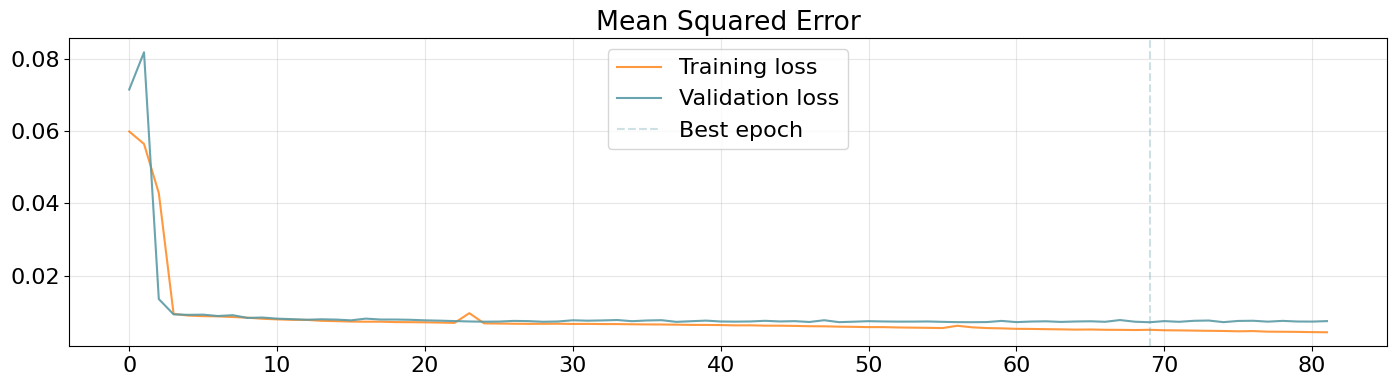

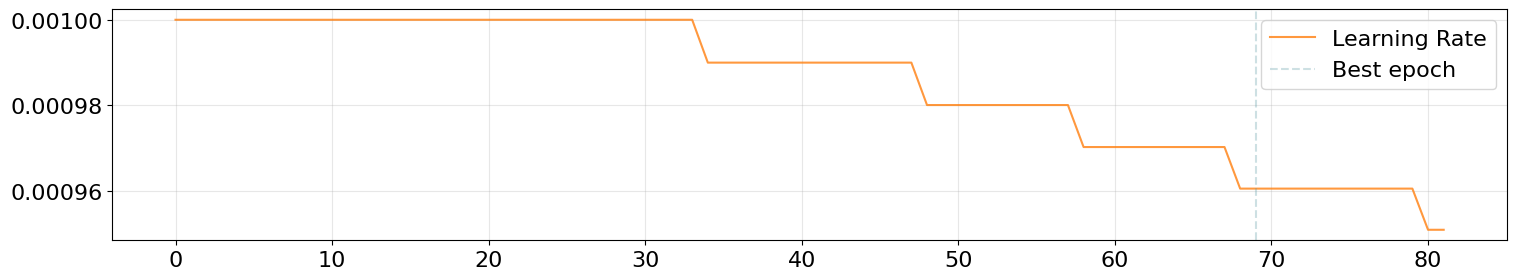

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### Model 1

In [ ]:
print(f"X_train: {X_train1.shape}, y_train: {y_train1.shape}")
print(f"X_val: {X_val1.shape}, y_train: {y_val1.shape}")

input_shape = (X_train1.shape[1],1)
output_shape = (y_train1.shape[1],1)
batch_size = 64
epochs = 200

early_stopping = tfk.callbacks.EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  patience=12,
                  restore_best_weights=True)

lr_scheduling = tfk.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  mode='min',
                  patience=10,
                  factor=0.99,
                  min_lr=1e-5)

print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (37750, 200), y_train: (37750, 9)
X_val: (6520, 200), y_train: (6520, 9)
Input shape: (200, 1), output shape: (9, 1)


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 bidirectional_lstm_2 (Bidi  (None, 200, 256)             394240    ['bidirectional_lstm[0][0]']  
 rectional)                                                                                       
                                                                                    

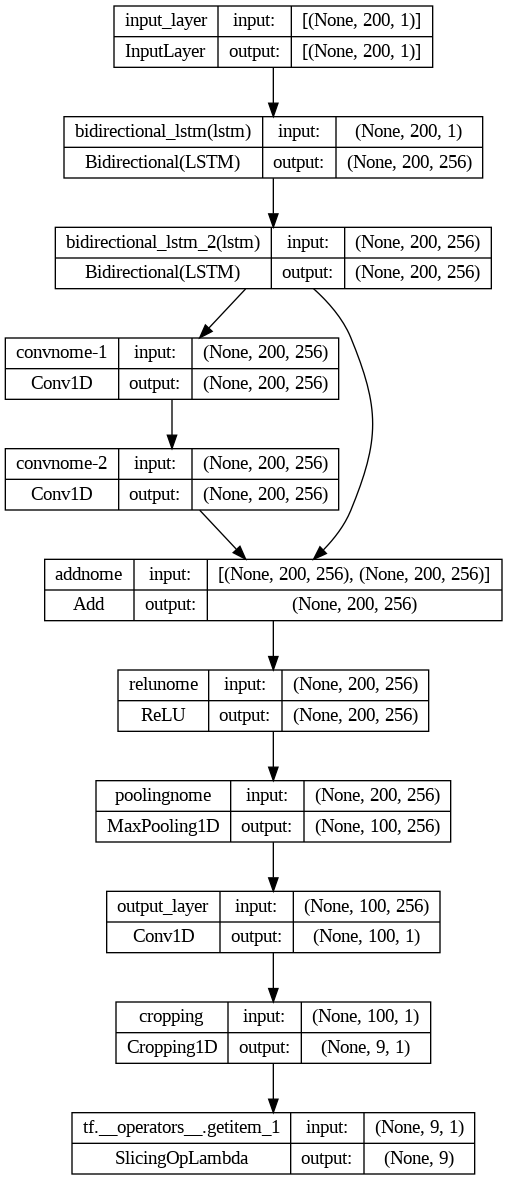

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train1,
    y = y_train1,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val1, y_val1),
    callbacks = [early_stopping, lr_scheduling]
).history

Epoch 1/200
590/590 [==============================] - 40s 52ms/step - loss: 0.0589 - val_loss: 0.0686 - lr: 0.0010
Epoch 2/200
590/590 [==============================] - 29s 49ms/step - loss: 0.0692 - val_loss: 0.0633 - lr: 0.0010
Epoch 3/200
590/590 [==============================] - 29s 48ms/step - loss: 0.0700 - val_loss: 0.0665 - lr: 0.0010
Epoch 4/200
590/590 [==============================] - 30s 50ms/step - loss: 0.0296 - val_loss: 0.0093 - lr: 0.0010
Epoch 5/200
590/590 [==============================] - 29s 49ms/step - loss: 0.0105 - val_loss: 0.0095 - lr: 0.0010
Epoch 6/200
590/590 [==============================] - 29s 49ms/step - loss: 0.0101 - val_loss: 0.0084 - lr: 0.0010
Epoch 7/200
590/590 [==============================] - 29s 49ms/step - loss: 0.0098 - val_loss: 0.0092 - lr: 0.0010
Epoch 8/200
590/590 [==============================] - 30s 50ms/step - loss: 0.0096 - val_loss: 0.0083 - lr: 0.0010
Epoch 9/200
590/590 [==============================] - 29s 49ms/step - l

In [ ]:
model.save('CategoriesModels/DirectForecasting_ResNet_Cat1')

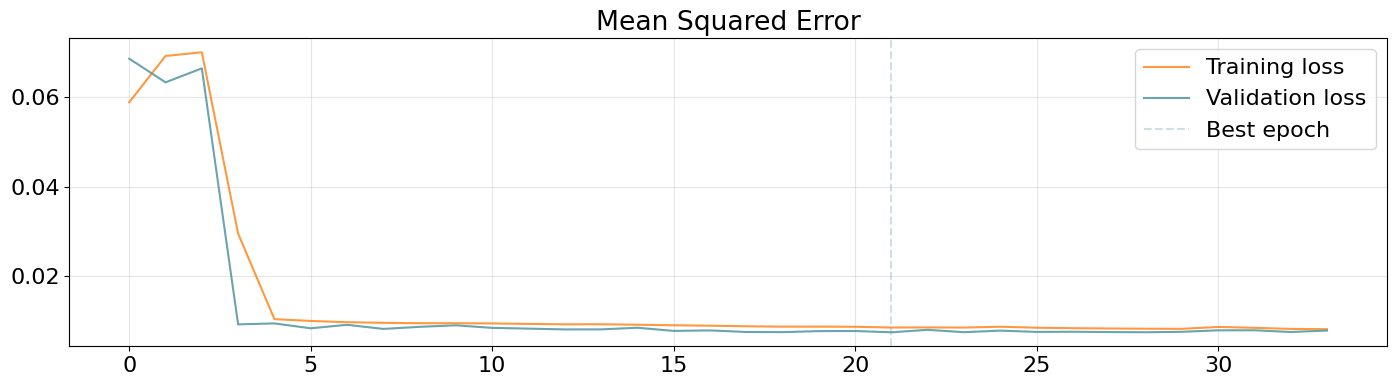

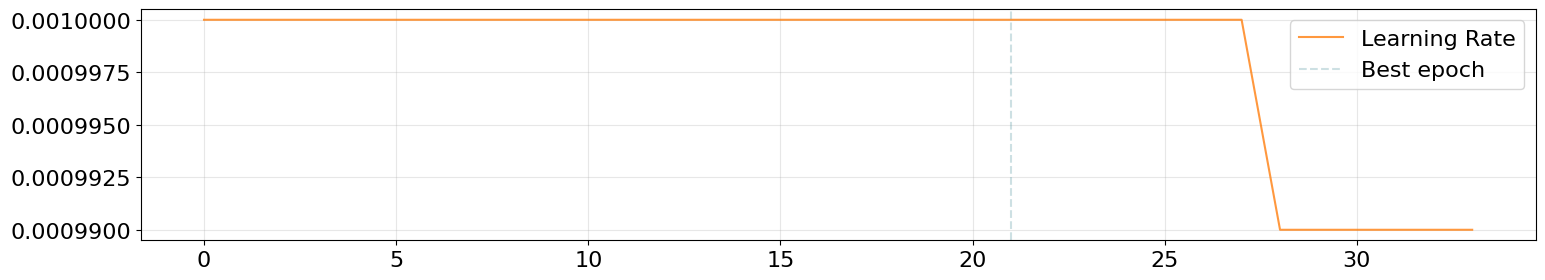

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### Model 2

In [ ]:
print(f"X_train: {X_train2.shape}, y_train: {y_train2.shape}")
print(f"X_val: {X_val2.shape}, y_train: {y_val2.shape}")

input_shape = (X_train2.shape[1],1)
output_shape = (y_train2.shape[1],1)
batch_size = 64
epochs = 200

early_stopping = tfk.callbacks.EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  patience=12,
                  restore_best_weights=True)

lr_scheduling = tfk.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  mode='min',
                  patience=10,
                  factor=0.99,
                  min_lr=1e-5)

print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (58499, 200), y_train: (58499, 9)
X_val: (5170, 200), y_train: (5170, 9)
Input shape: (200, 1), output shape: (9, 1)


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 bidirectional_lstm_2 (Bidi  (None, 200, 256)             394240    ['bidirectional_lstm[0][0]']  
 rectional)                                                                                       
                                                                                    

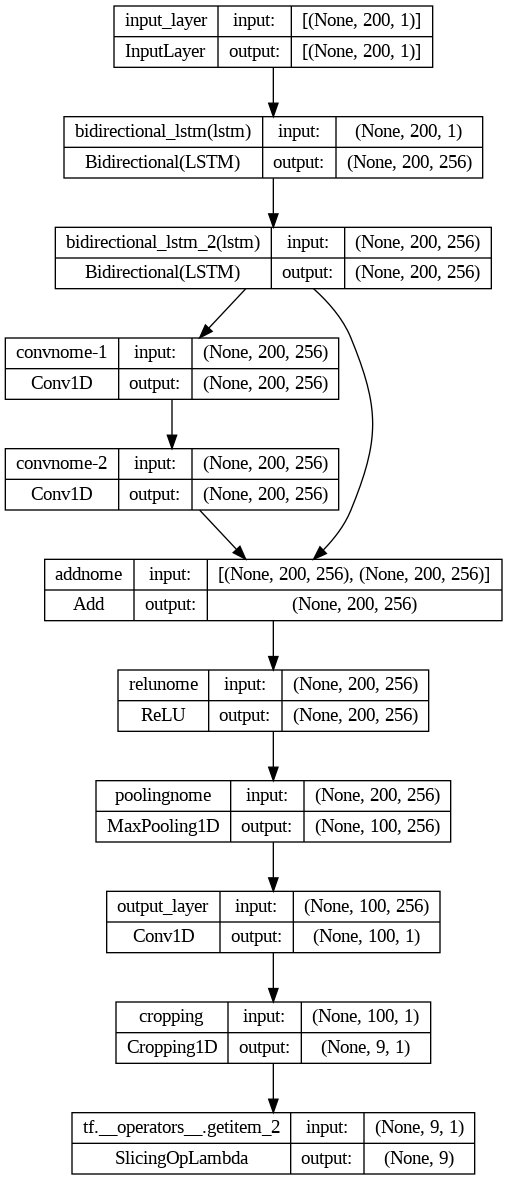

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train2,
    y = y_train2,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val2, y_val2),
    callbacks = [early_stopping, lr_scheduling]
).history

Epoch 1/200
915/915 [==============================] - 56s 51ms/step - loss: 0.0665 - val_loss: 0.0660 - lr: 0.0010
Epoch 2/200
915/915 [==============================] - 43s 48ms/step - loss: 0.0641 - val_loss: 0.0675 - lr: 0.0010
Epoch 3/200
915/915 [==============================] - 44s 48ms/step - loss: 0.0515 - val_loss: 0.0095 - lr: 0.0010
Epoch 4/200
915/915 [==============================] - 44s 48ms/step - loss: 0.0096 - val_loss: 0.0089 - lr: 0.0010
Epoch 5/200
915/915 [==============================] - 44s 48ms/step - loss: 0.0092 - val_loss: 0.0096 - lr: 0.0010
Epoch 6/200
915/915 [==============================] - 43s 47ms/step - loss: 0.0089 - val_loss: 0.0091 - lr: 0.0010
Epoch 7/200
915/915 [==============================] - 43s 47ms/step - loss: 0.0086 - val_loss: 0.0090 - lr: 0.0010
Epoch 8/200
915/915 [==============================] - 43s 47ms/step - loss: 0.0080 - val_loss: 0.0076 - lr: 0.0010
Epoch 9/200
915/915 [==============================] - 43s 47ms/step - l

In [ ]:
model.save('CategoriesModels/DirectForecasting_ResNet_Cat2')

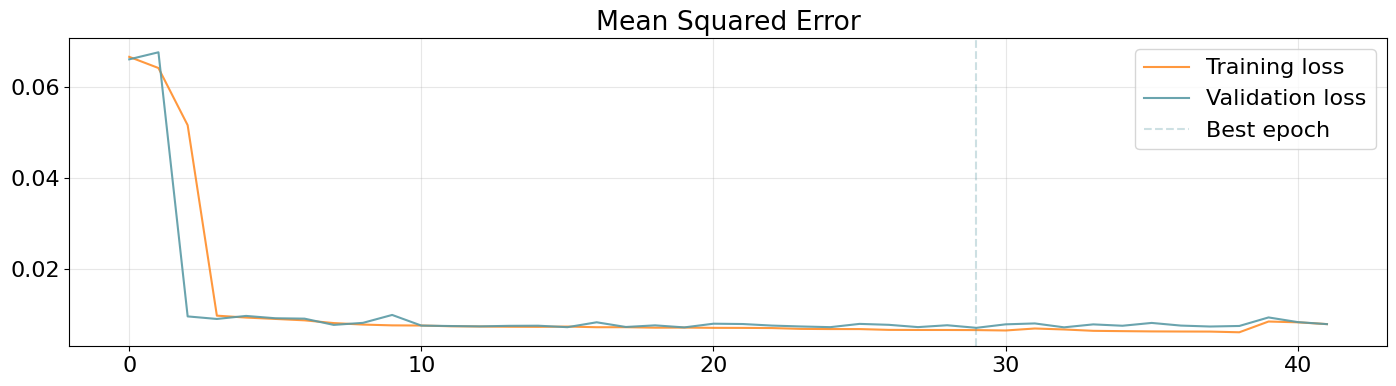

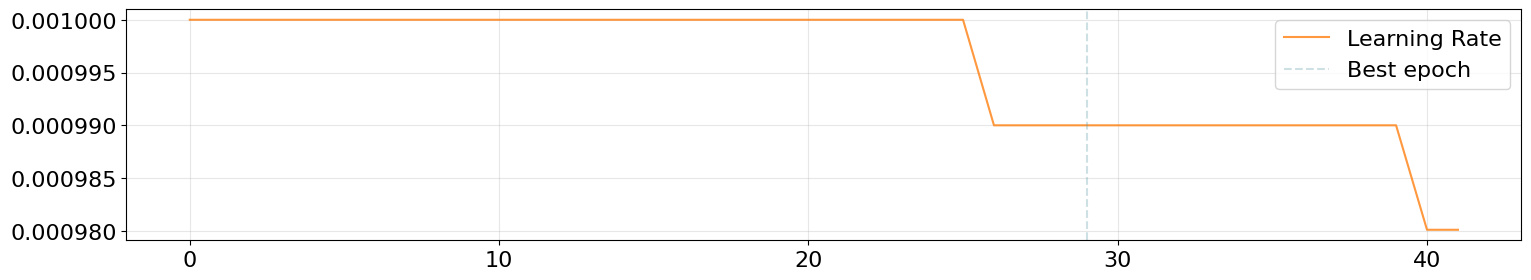

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### Model 3

In [ ]:
print(f"X_train: {X_train3.shape}, y_train: {y_train3.shape}")
print(f"X_val: {X_val3.shape}, y_train: {y_val3.shape}")

input_shape = (X_train3.shape[1],1)
output_shape = (y_train3.shape[1],1)
batch_size = 64
epochs = 200

early_stopping = tfk.callbacks.EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  patience=12,
                  restore_best_weights=True)

lr_scheduling = tfk.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  mode='min',
                  patience=10,
                  factor=0.99,
                  min_lr=1e-5)

print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (60639, 200), y_train: (60639, 9)
X_val: (6050, 200), y_train: (6050, 9)
Input shape: (200, 1), output shape: (9, 1)


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 bidirectional_lstm_2 (Bidi  (None, 200, 256)             394240    ['bidirectional_lstm[0][0]']  
 rectional)                                                                                       
                                                                                    

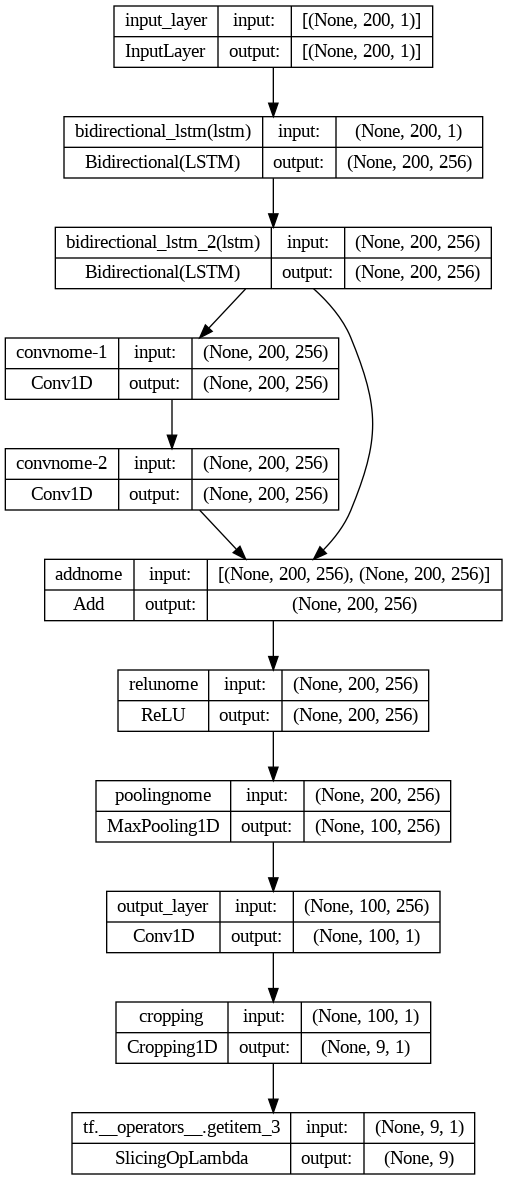

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train3,
    y = y_train3,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val3, y_val3),
    callbacks = [early_stopping, lr_scheduling]
).history

Epoch 1/200
948/948 [==============================] - 58s 50ms/step - loss: 0.0576 - val_loss: 0.0619 - lr: 0.0010
Epoch 2/200
948/948 [==============================] - 45s 47ms/step - loss: 0.0545 - val_loss: 0.0646 - lr: 0.0010
Epoch 3/200
948/948 [==============================] - 45s 48ms/step - loss: 0.0473 - val_loss: 0.0494 - lr: 0.0010
Epoch 4/200
948/948 [==============================] - 44s 47ms/step - loss: 0.0422 - val_loss: 0.0377 - lr: 0.0010
Epoch 5/200
948/948 [==============================] - 44s 47ms/step - loss: 0.0339 - val_loss: 0.0116 - lr: 0.0010
Epoch 6/200
948/948 [==============================] - 45s 47ms/step - loss: 0.0104 - val_loss: 0.0105 - lr: 0.0010
Epoch 7/200
948/948 [==============================] - 45s 47ms/step - loss: 0.0093 - val_loss: 0.0089 - lr: 0.0010
Epoch 8/200
948/948 [==============================] - 45s 48ms/step - loss: 0.0090 - val_loss: 0.0086 - lr: 0.0010
Epoch 9/200
948/948 [==============================] - 45s 47ms/step - l

In [ ]:
model.save('CategoriesModels/DirectForecasting_ResNet_Cat3')

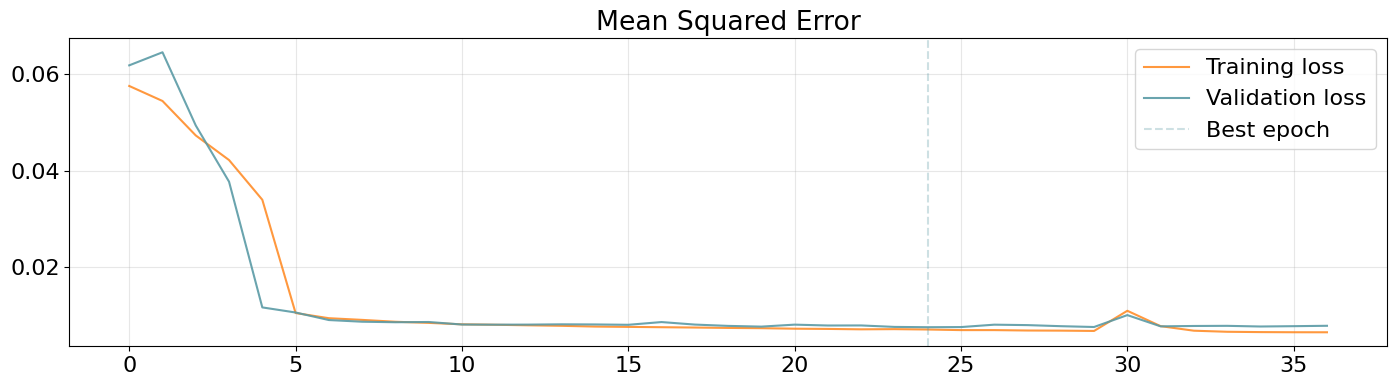

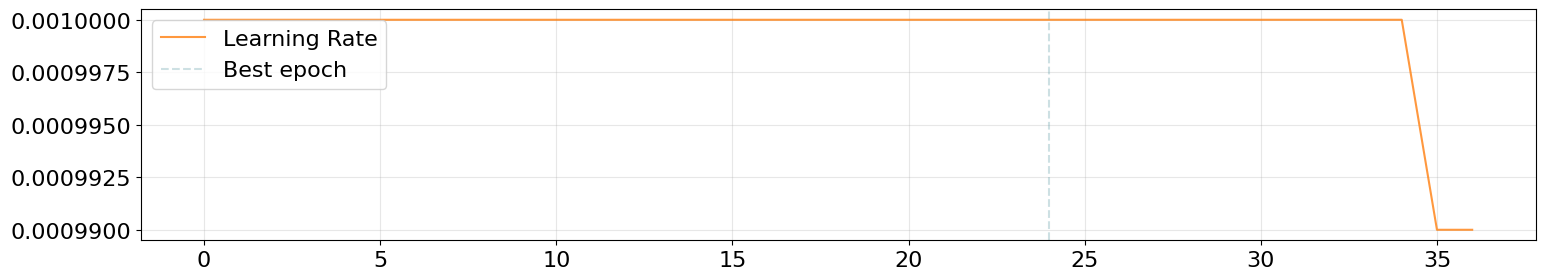

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### Model 4

In [ ]:
print(f"X_train: {X_train4.shape}, y_train: {y_train4.shape}")
print(f"X_val: {X_val4.shape}, y_train: {y_val4.shape}")

input_shape = (X_train4.shape[1],1)
output_shape = (y_train4.shape[1],1)
batch_size = 64
epochs = 200

early_stopping = tfk.callbacks.EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  patience=12,
                  restore_best_weights=True)

lr_scheduling = tfk.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  mode='min',
                  patience=10,
                  factor=0.99,
                  min_lr=1e-5)

print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (41789, 200), y_train: (41789, 9)
X_val: (6710, 200), y_train: (6710, 9)
Input shape: (200, 1), output shape: (9, 1)


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 bidirectional_lstm_2 (Bidi  (None, 200, 256)             394240    ['bidirectional_lstm[0][0]']  
 rectional)                                                                                       
                                                                                    

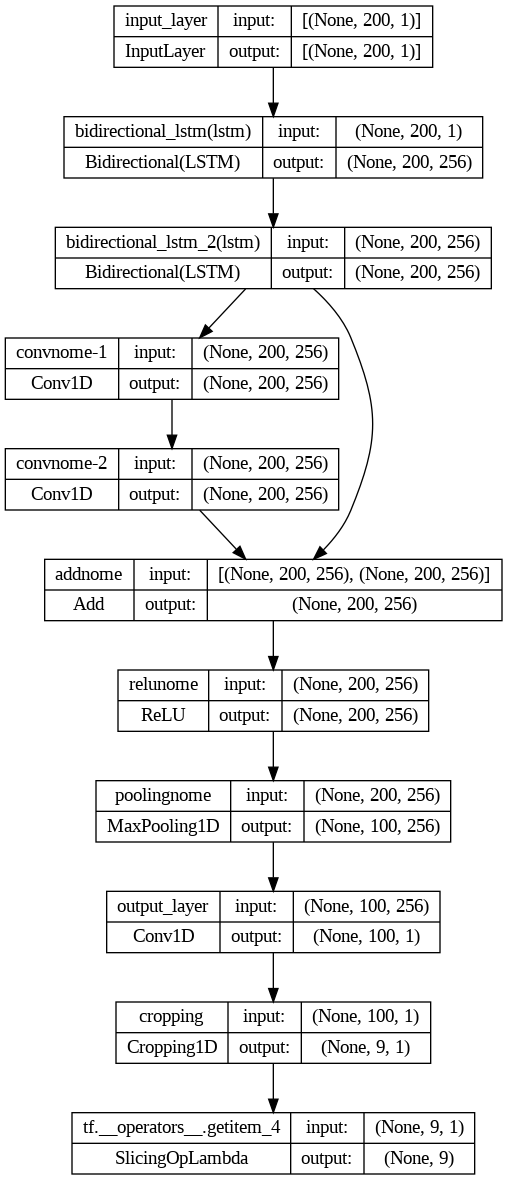

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train4,
    y = y_train4,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val4, y_val4),
    callbacks = [early_stopping, lr_scheduling]
).history

Epoch 1/200
653/653 [==============================] - 43s 53ms/step - loss: 0.0640 - val_loss: 0.0510 - lr: 0.0010
Epoch 2/200
653/653 [==============================] - 32s 49ms/step - loss: 0.0638 - val_loss: 0.0572 - lr: 0.0010
Epoch 3/200
653/653 [==============================] - 32s 49ms/step - loss: 0.0444 - val_loss: 0.0101 - lr: 0.0010
Epoch 4/200
653/653 [==============================] - 32s 49ms/step - loss: 0.0096 - val_loss: 0.0093 - lr: 0.0010
Epoch 5/200
653/653 [==============================] - 33s 51ms/step - loss: 0.0089 - val_loss: 0.0097 - lr: 0.0010
Epoch 6/200
653/653 [==============================] - 32s 49ms/step - loss: 0.0086 - val_loss: 0.0089 - lr: 0.0010
Epoch 7/200
653/653 [==============================] - 32s 49ms/step - loss: 0.0084 - val_loss: 0.0085 - lr: 0.0010
Epoch 8/200
653/653 [==============================] - 32s 49ms/step - loss: 0.0083 - val_loss: 0.0088 - lr: 0.0010
Epoch 9/200
653/653 [==============================] - 32s 49ms/step - l

In [ ]:
model.save('CategoriesModels/DirectForecasting_ResNet_Cat4')

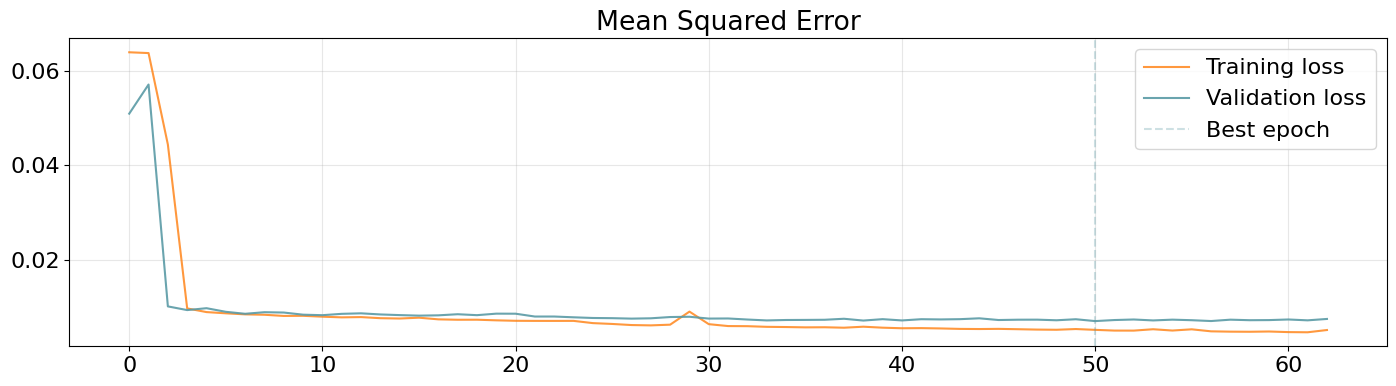

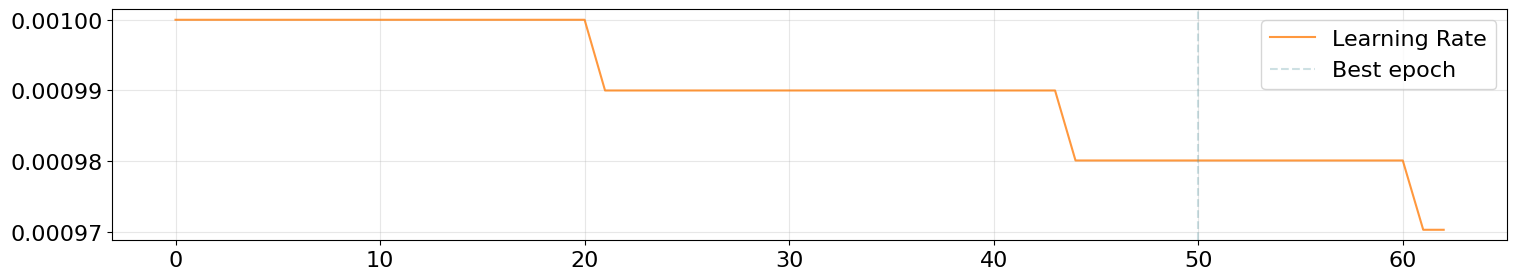

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### Model 5

In [ ]:
print(f"X_train: {X_train5.shape}, y_train: {y_train5.shape}")
print(f"X_val: {X_val5.shape}, y_train: {y_val5.shape}")

input_shape = (X_train5.shape[1],1)
output_shape = (y_train5.shape[1],1)
batch_size = 64
epochs = 200

early_stopping = tfk.callbacks.EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  patience=12,
                  restore_best_weights=True)

lr_scheduling = tfk.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  mode='min',
                  patience=10,
                  factor=0.99,
                  min_lr=1e-5)

print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (1470, 200), y_train: (1470, 9)
X_val: (160, 200), y_train: (160, 9)
Input shape: (200, 1), output shape: (9, 1)


Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 256)             133120    ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 bidirectional_lstm_2 (Bidi  (None, 200, 256)             394240    ['bidirectional_lstm[0][0]']  
 rectional)                                                                                       
                                                                                    

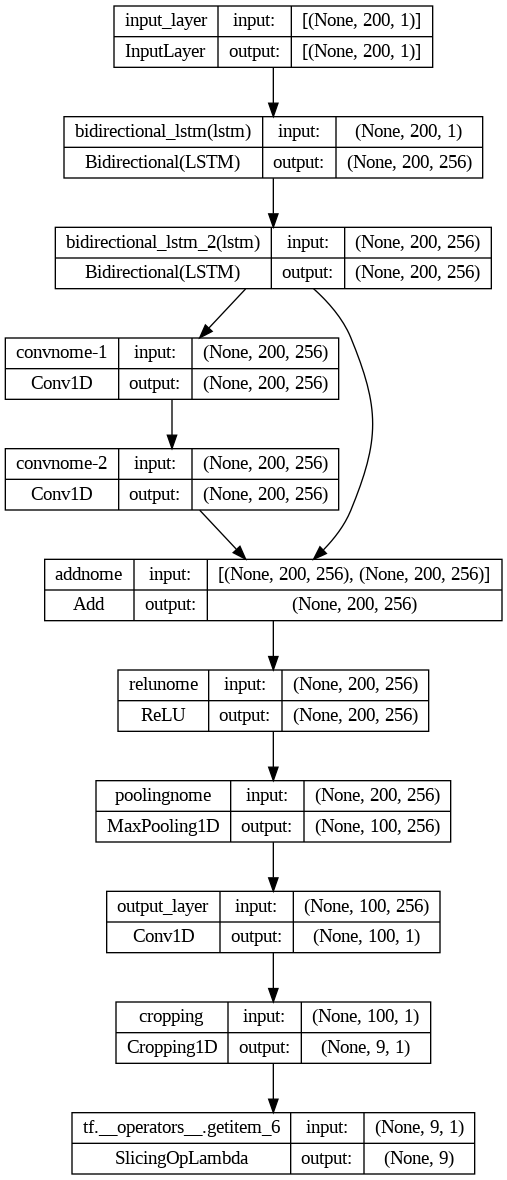

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train5,
    y = y_train5,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val5, y_val5),
    callbacks = [early_stopping, lr_scheduling]
).history

Epoch 1/200
23/23 [==============================] - 12s 185ms/step - loss: 0.1084 - val_loss: 0.1069 - lr: 0.0010
Epoch 2/200
23/23 [==============================] - 2s 91ms/step - loss: 0.0802 - val_loss: 0.0790 - lr: 0.0010
Epoch 3/200
23/23 [==============================] - 2s 106ms/step - loss: 0.0793 - val_loss: 0.0869 - lr: 0.0010
Epoch 4/200
23/23 [==============================] - 2s 100ms/step - loss: 0.0810 - val_loss: 0.0766 - lr: 0.0010
Epoch 5/200
23/23 [==============================] - 1s 49ms/step - loss: 0.0788 - val_loss: 0.0729 - lr: 0.0010
Epoch 6/200
23/23 [==============================] - 1s 49ms/step - loss: 0.0774 - val_loss: 0.0810 - lr: 0.0010
Epoch 7/200
23/23 [==============================] - 1s 48ms/step - loss: 0.0775 - val_loss: 0.0793 - lr: 0.0010
Epoch 8/200
23/23 [==============================] - 1s 49ms/step - loss: 0.0795 - val_loss: 0.0757 - lr: 0.0010
Epoch 9/200
23/23 [==============================] - 1s 49ms/step - loss: 0.0777 - val_loss:

In [ ]:
model.save('CategoriesModels/DirectForecasting_ResNet_Cat5')

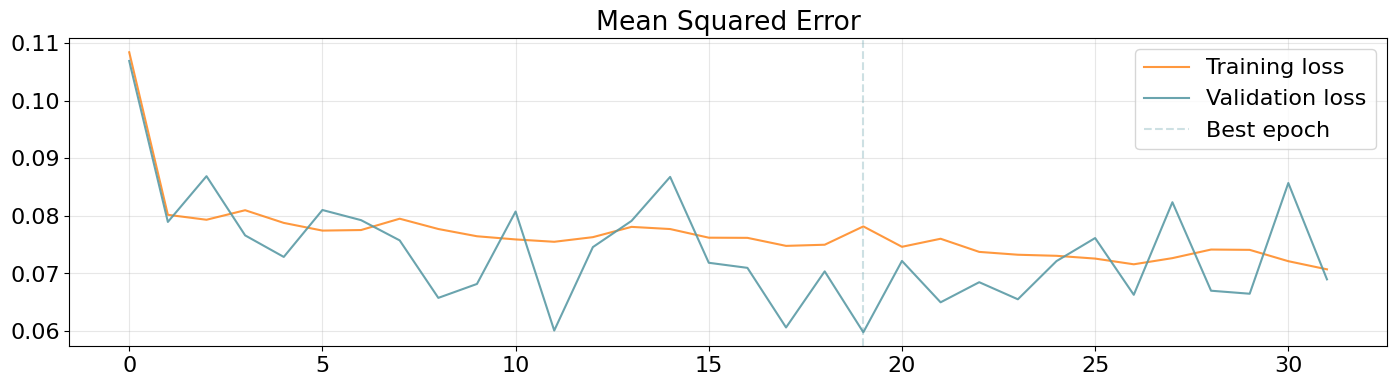

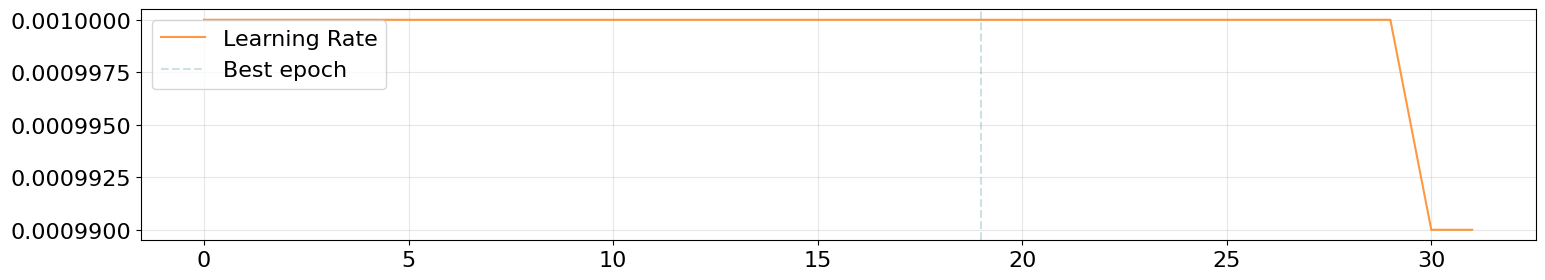

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()